In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from n_framework import *
from activations_module import*

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)   

In [ ]:
set_seed(42)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]
     

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [ ]:
def get_model():
    return nn.Sequential(conv(1,8),conv(8,16),conv(16,32),conv(32,64),
                        conv(64,10, act=False), nn.Flatten()).to(def_device)

In [ ]:
lrf_cbs = [DeviceCB(),ProgressCB(),LRFinderCB()]
learn = MomentumLearner(get_model(),dls,F.cross_entropy,lr=1e-4,cbs=lrf_cbs)

In [ ]:
lrf_cbs = [DeviceCB(),ProgressCB(),LRFinderCB(gamma=1.1)]
learn = MomentumLearner(get_model(),dls,F.cross_entropy,lr=1e-2,cbs=lrf_cbs)

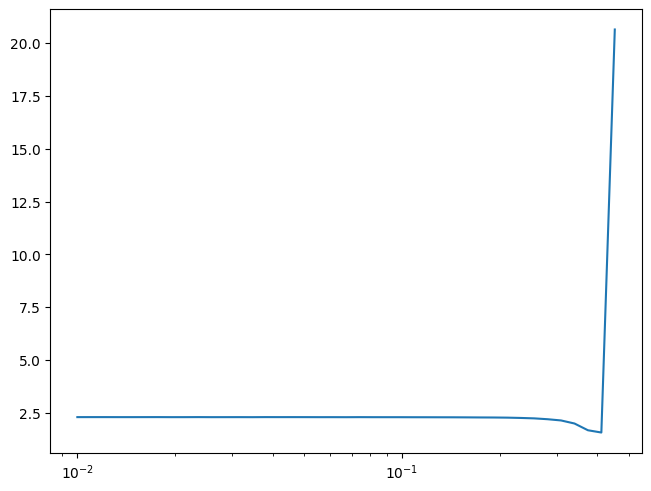

In [ ]:
learn.fit(1)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(),ProgressCB(plot=True),metrics, astats]
learn = MomentumLearner(get_model(),dls,F.cross_entropy,lr=0.2,cbs=cbs)

accuracy,loss,epoch,train
0.163,2.391,0,train
0.100,2.320,0,eval


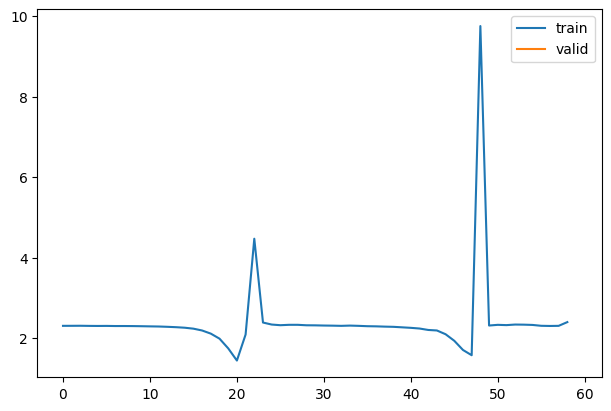

In [ ]:
learn.fit(1)

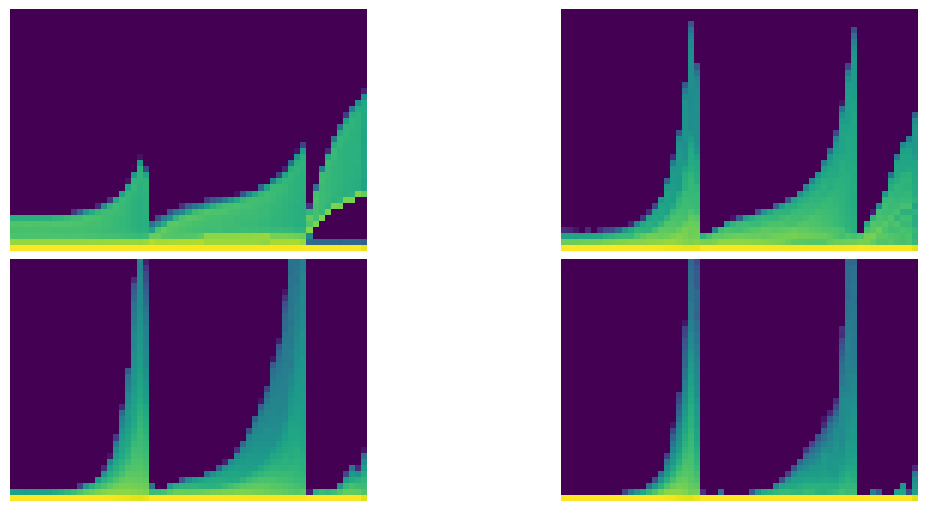

In [ ]:
astats.color_dim()

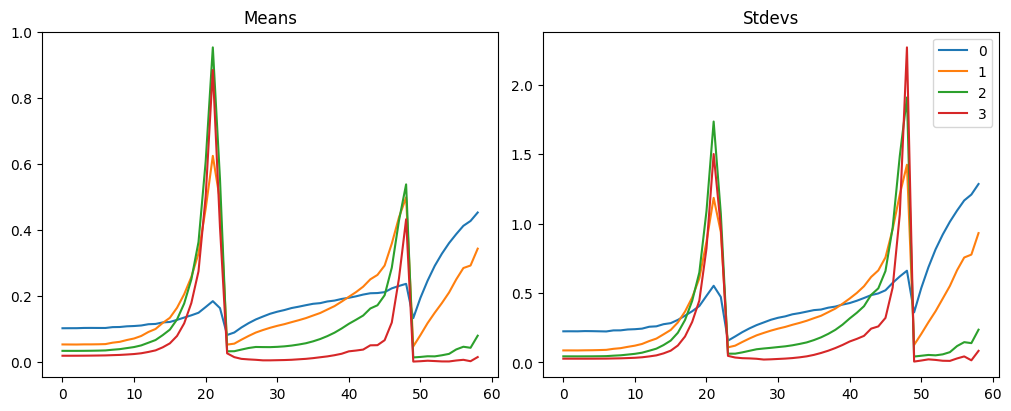

In [ ]:
astats.plot_stats()

In [ ]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [ ]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [ ]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
clean_mem()

### Glorot/initi

In [ ]:
x = torch.randn(200,100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [ ]:
x = torch.randn(200,100)
for i in range(50): x = x @ (torch.randn(100,100)*0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

 Xavior Glorot init
 So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in "Understanding the Difficulty of Training Deep Feedforward Neural Networks".
 The right scale for a given layer is [ 1/(n_inputs)^1/2 ]

In [ ]:
x = torch.randn(200,100)
for i in range(50): x = x @ (torch.randn(100,100)*0.1)
x[0:5,0:5]

tensor([[-0.75,  0.10, -0.30,  0.01, -0.35],
        [ 0.42, -0.02,  0.07, -0.28,  0.10],
        [-0.56, -1.19, -1.57,  0.06, -0.58],
        [-0.10, -0.40, -0.48,  0.44, -0.16],
        [ 0.43,  0.81,  1.02, -0.09,  0.53]])

after applying xaviar glorot initiailization method our activations are not 'nan' or 0. 

### Variance, Standard Deviation,Covarinace 

In [ ]:
t= torch.tensor([1.,2.,4.,18.])

In [ ]:
m = t.mean();m

tensor(6.25)

In [ ]:
(t-m).mean()

tensor(0.)

In [ ]:
# this is Variance
(t-m).pow(2).mean()

tensor(47.19)

In [ ]:
#this is mean absolute difference
(t-m).abs().mean()

tensor(5.88)

In [ ]:
# this is Standard devaition
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [ ]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

In [ ]:
((t-m)*(t-m)).mean()

tensor(47.19)

Covariance

In [ ]:
t

tensor([ 1.,  2.,  4., 18.])

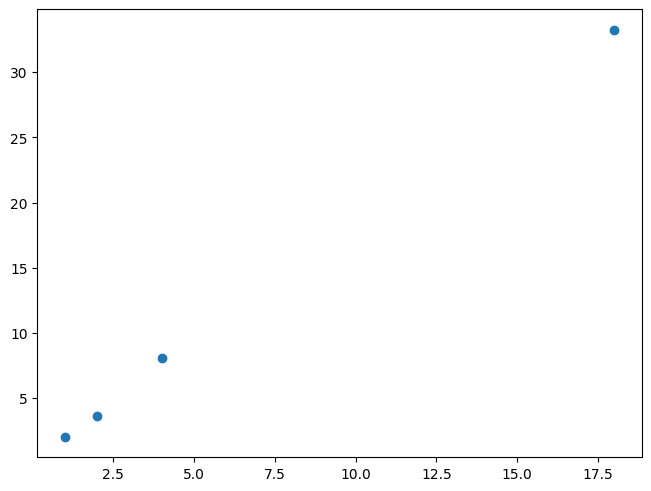

In [ ]:
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [ ]:
prod = (t-t.mean())*(u-u.mean());prod

tensor([ 51.07,  34.61,   8.22, 252.88])

In [ ]:
prod.mean()

tensor(86.69)

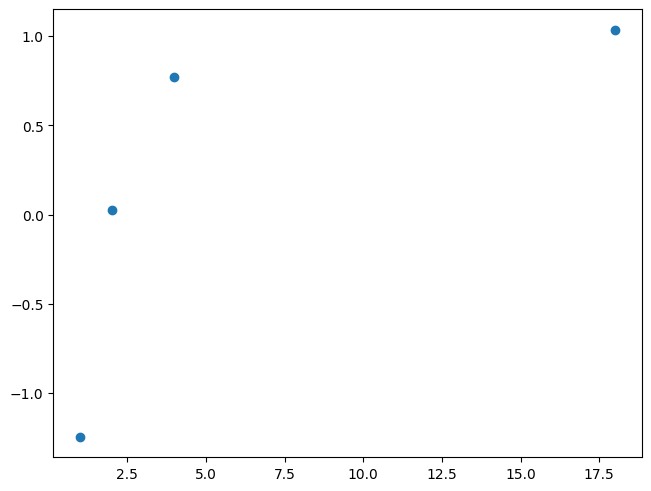

In [ ]:
v= torch.randn_like(t)
plt.scatter(t,v);

In [ ]:
((t-t.mean())*(v-v.mean())).mean()

tensor(4.22)

In [ ]:
conva = (t*v).mean() - t.mean()*v.mean();conva

tensor(4.22)

## Pearsons correlation
its the just convariance devided by the product of their standard deviations

In [ ]:
 conva/(t.std()*v.std())

tensor(0.52)

### Kaiming init


In [ ]:
x=torch.randn(200,100)
y=torch.randn(200)

In [ ]:
from math import sqrt

In [ ]:
w1 = torch.randn(100,50)/sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1)/sqrt(50)
b2 = torch.zeros(1)

In [ ]:
def lin(x,w,b): return x @ w + b

In [ ]:
l1 = lin(x,w1,b1)
l1.mean(),l1.std()

(tensor(0.00), tensor(1.00))

In [ ]:
def relu(x):return x.clamp_min(0.)

In [ ]:
l2 = relu(l1)
l2.mean(),l2.std()

(tensor(0.40), tensor(0.59))

using the Glorot initialization we multiply by [ 1/(sqrt(n_inp))] in this case ([1/sqrt(100)] = 1/10)
But the relu function is squeezing the values so it doesnt work

In [ ]:
x =torch.randn(200,100)
for i in range(50): x = relu(x @ (torch.randn(100,100)*0.1))

x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

##### Kaiming inti 
* In "Delving Deep into Rectifiers: Surpassing Human-Level Performance" Kaiming He et al. show that we should use the following scale instead: [ sqrt(2/n_inp)], where n_inp is the number of inputs


In [ ]:
x =torch.randn(200,100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))

x[0:5,0:5]

tensor([[0.00, 0.00, 0.50, 0.00, 0.00],
        [0.00, 0.00, 0.76, 0.00, 0.00],
        [0.00, 0.00, 0.62, 0.00, 0.00],
        [0.00, 0.00, 1.96, 0.00, 0.00],
        [0.00, 0.00, 2.31, 0.00, 0.00]])

### Applyig Kaiming init 

In [ ]:
model =get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
def init_weights(m):
    if isinstance(m,(nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight)

In [ ]:
model.apply(init_weights);

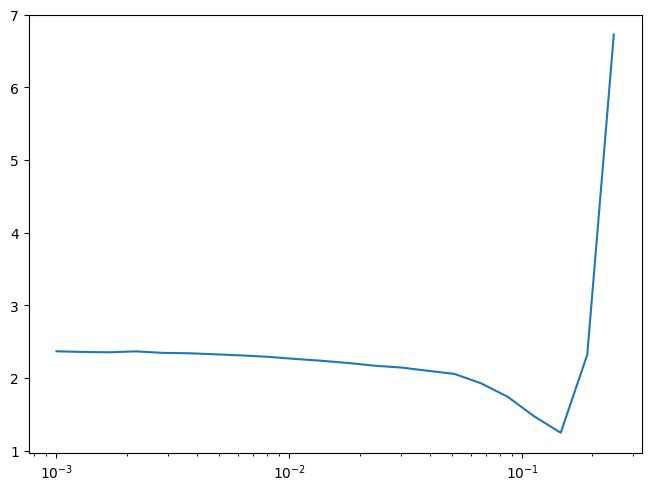

In [ ]:
lrf_cbs = [DeviceCB(),ProgressCB(),LRFinderCB()]
learn = MomentumLearner(model,dls, F.cross_entropy,lr=1e-3,cbs=lrf_cbs)
learn.fit(1)

accuracy,loss,epoch,train
0.603,1.157,0,train
0.798,0.541,0,eval
0.832,0.455,1,train
0.843,0.442,1,eval
0.857,0.386,2,train
0.856,0.400,2,eval


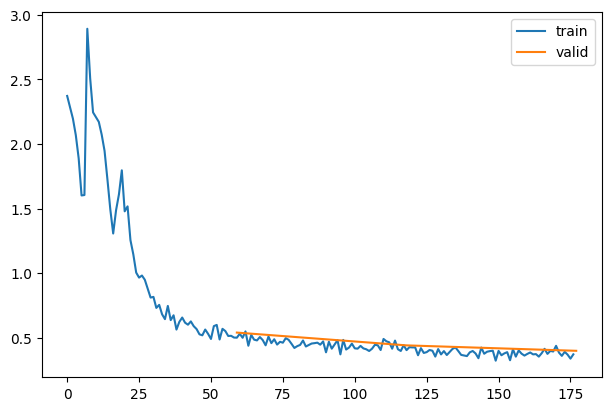

In [ ]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy,lr=0.2,cbs=cbs)
learn.fit(3)

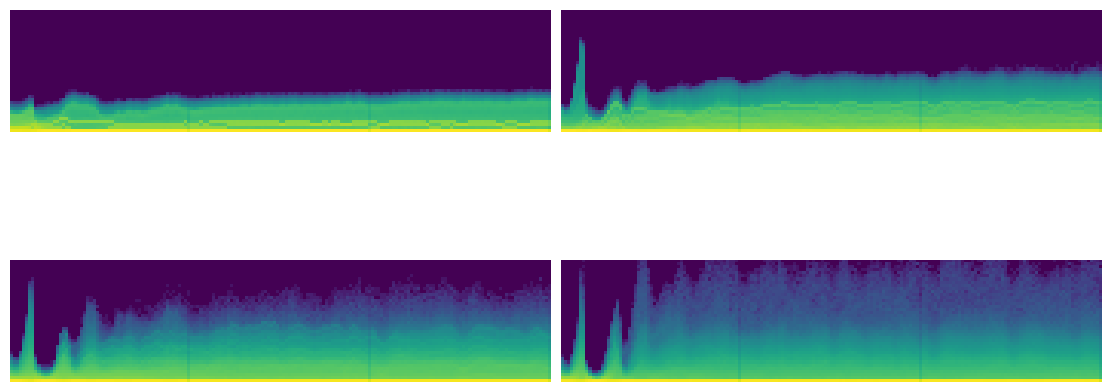

In [ ]:
astats.color_dim()

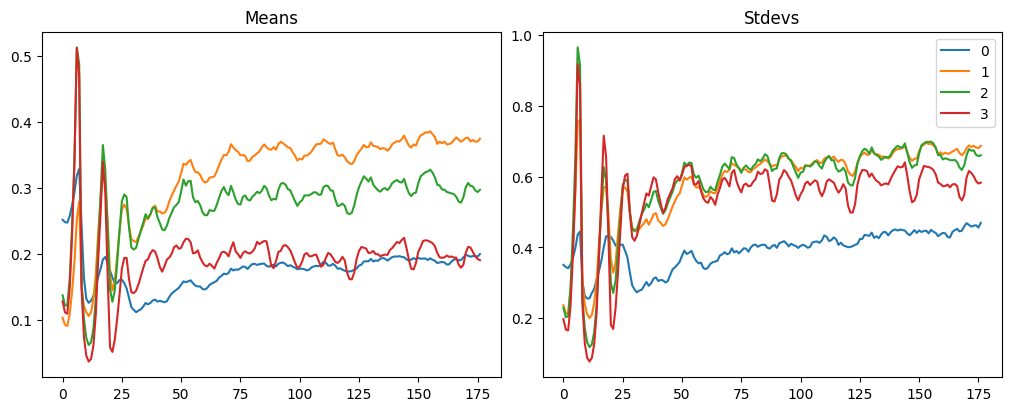

In [ ]:
astats.plot_stats()

### Input Normalization

In [ ]:
xmeans,xstd = xb.mean(),xb.std()
xmeans,xstd

(tensor(0.28), tensor(0.35))

In [ ]:
#|export
class BatchTransformCB(callback):
    def __init__(self,tfm): self.tfm=tfm
    def before_batch(self,learn): learn.batch = self.tfm(learn.batch)

In [ ]:
def _norm(b): return (b[0] - xmeans/xstd,b[1])
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.312,2.037,0,train
0.601,1.078,0,eval
0.743,0.714,1,train
0.772,0.604,1,eval
0.802,0.538,2,train
0.805,0.520,2,eval


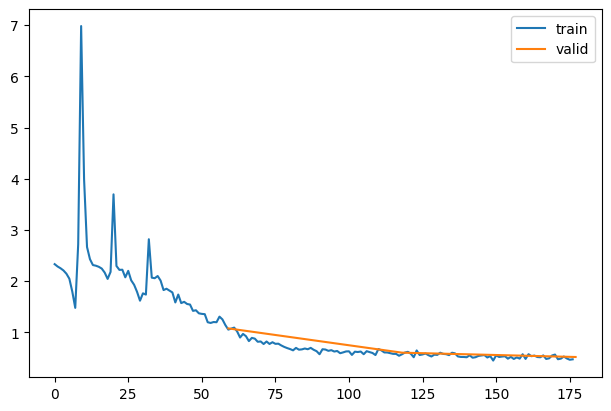

In [ ]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights),dls,F.cross_entropy,lr=0.2,cbs=cbs+[norm])
learn.fit(3)

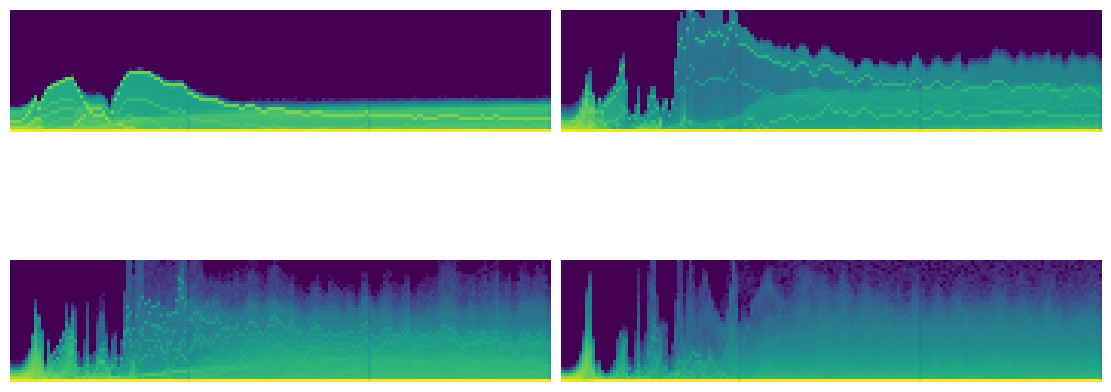

In [ ]:
astats.color_dim()

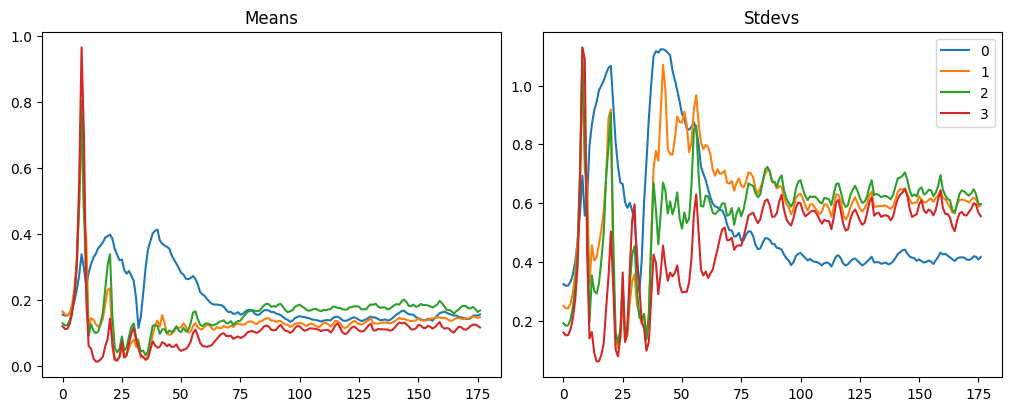

In [ ]:
astats.plot_stats()

In [ ]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmeans)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds,bs)
xb,yb = next(iter(dls.train))

In [ ]:
xb.mean(),xb.std()

(tensor(    0.00), tensor(1.))

## General ReLU

In [ ]:
#| export
class GeneralReLU(nn.Module):
    def __init__(self,leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv
        
    def forward(self,x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max(self.maxv)
        return x

In [ ]:
#|export
def plot_func(f, start=-5., end=5.,steps=100):
    x=torch.linspace(start,end,steps)
    plt.plot(x,f(x))
    plt.grid(True, which='both',ls = '--')
    plt.axhline(y=0,color='k',linewidth=0.7)
    plt.axvline(x=0,color='k', linewidth=0.7)

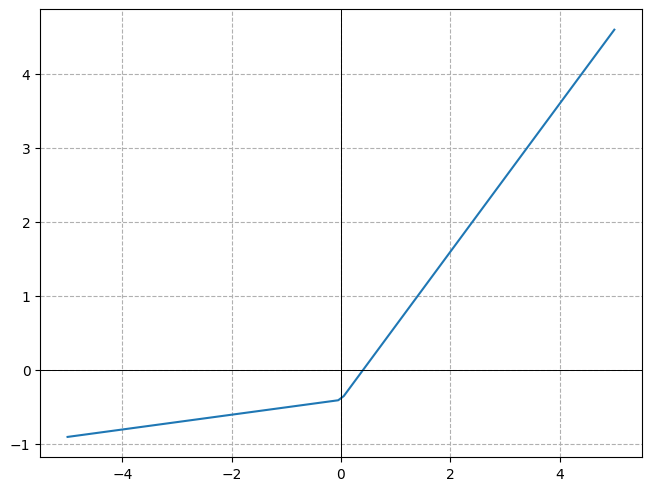

In [ ]:
plot_func(GeneralReLU(leak=0.1,sub=0.4))

In [ ]:
def conv(ni,nf,ks=3,stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni,nf,stride=stride,kernel_size=ks,padding=ks//2)
    if act:res = nn.Sequential(res,act())
    return res

In [ ]:
def get_model(act=nn.ReLU,nfs=None):
    if nfs is None: nfs=[1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1],act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers,conv(nfs[-1],10,act=None), nn.Flatten()).to(def_device)

In [ ]:
#|export 
#per
def init_weights(m,leaky=0.):
    if isinstance(m,(nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight,a=leaky)

In [ ]:
act_gr= partial(GeneralReLU,leak=0.1,sub=0.4) # activation function
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(),metrics,ProgressCB(plot=True), astats]
iw = partial(init_weights,leaky=0.1)

In [ ]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.162,nan,0,train
0.100,nan,0,eval
0.100,nan,1,train
0.100,nan,1,eval
0.100,nan,2,train
0.100,nan,2,eval


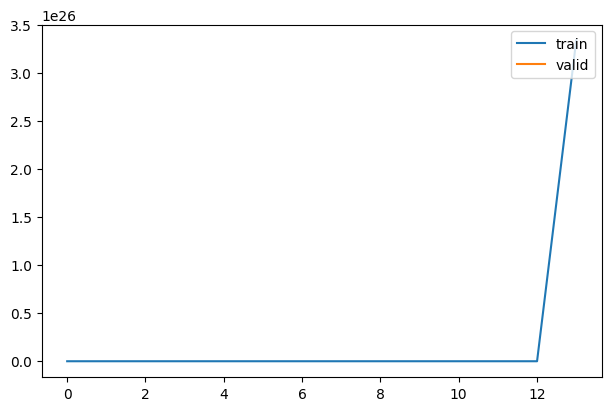

In [ ]:
set_seed(42)
learn= MomentumLearner(model,dls,F.cross_entropy,lr=0.2,cbs=cbs)
learn.fit(3)

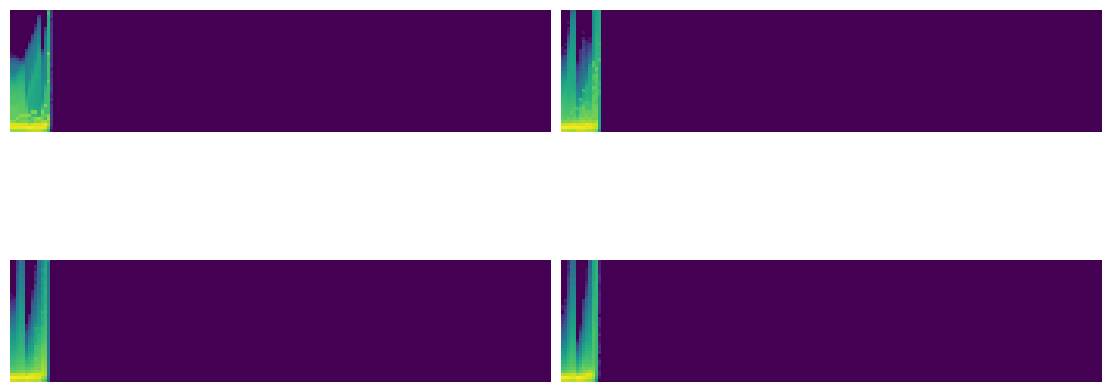

In [ ]:
astats.color_dim()

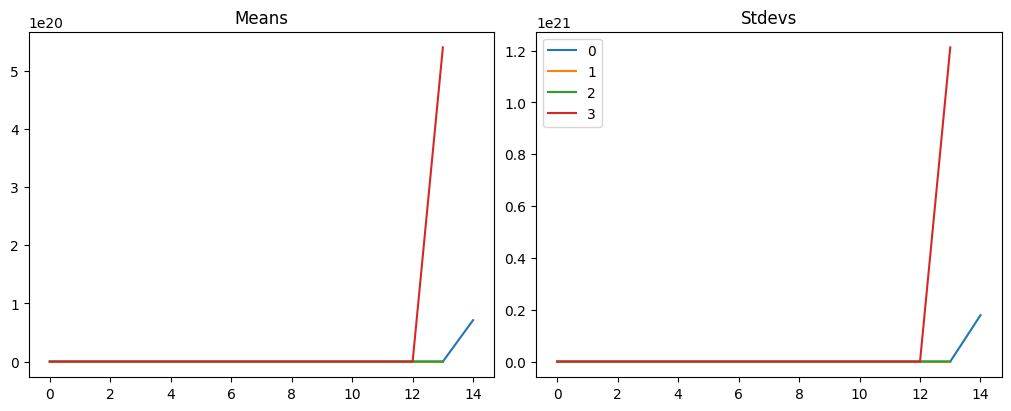

In [ ]:
astats.plot_stats()

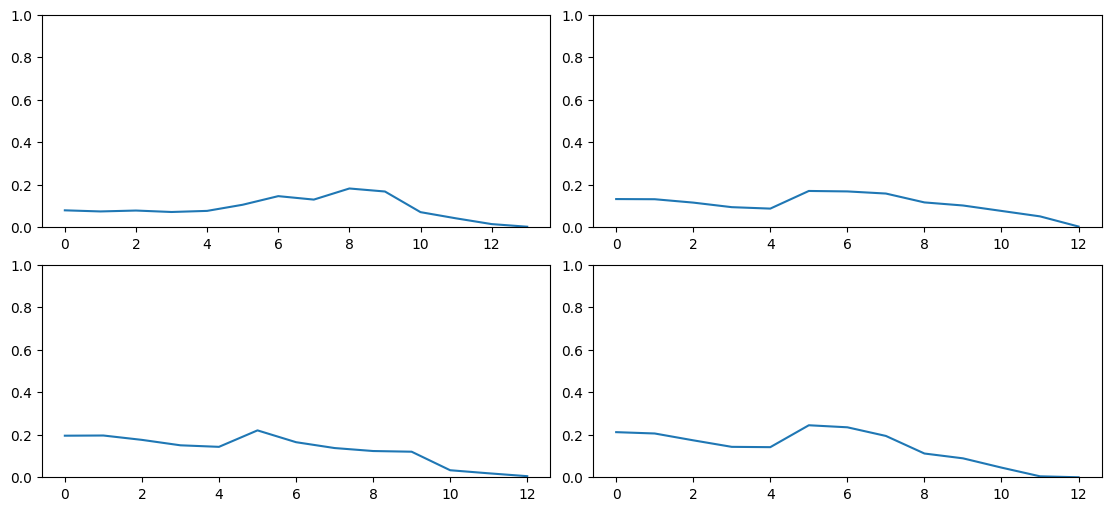

In [ ]:
astats.dead_chart()

 ## LSUV

In [ ]:
#|export
def _lsuv_stats(hook,mod,inp,outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()
    
def lsuv_init(m,m_in,xb):
    h = Hook(m,_lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std -1)>1e-3 or abs(h.mean)>1e-3):
            #print('before: ',h.mean,h.std)
            m_in.bias -=h.mean
            m_in.weight.data/=h.std
        #print('after:',h.mean,h.std)
    h.remove()

In [ ]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance (o,GeneralReLU)]
convs = [o for o in model.modules() if isinstance (o,nn.Conv2d)]

In [ ]:
for ms in zip(relus,convs): print(ms)

(GeneralReLU(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralReLU(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [ ]:
for ms in zip(relus,convs): lsuv_init(*ms, xb.to(def_device))

accuracy,loss,epoch,train
0.777,0.635,0,train
0.847,0.434,0,eval
0.862,0.375,1,train
0.853,0.411,1,eval
0.875,0.336,2,train
0.860,0.388,2,eval


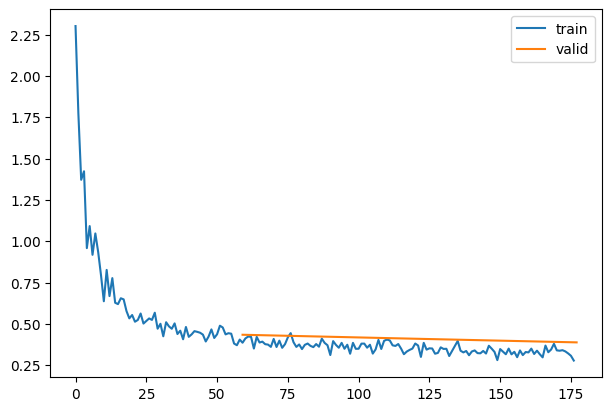

In [ ]:
set_seed(42)
learn = MomentumLearner(model,dls,F.cross_entropy,lr=0.2,cbs=cbs)
learn.fit(3)

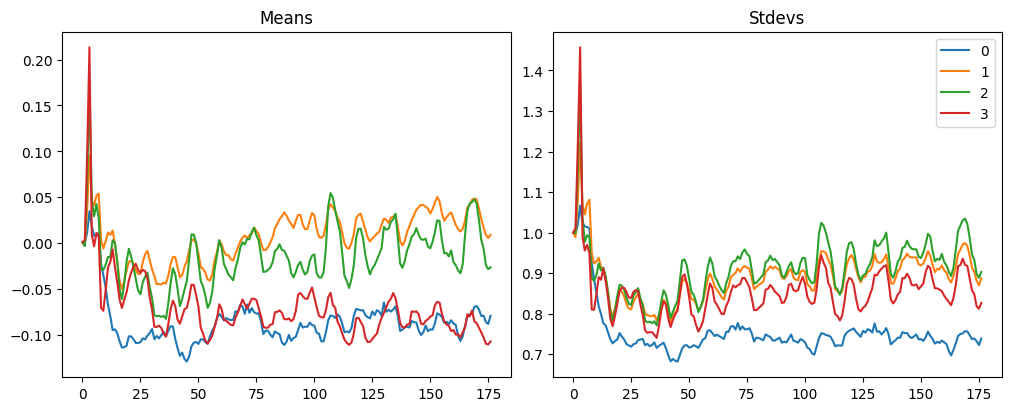

In [ ]:
astats.plot_stats()

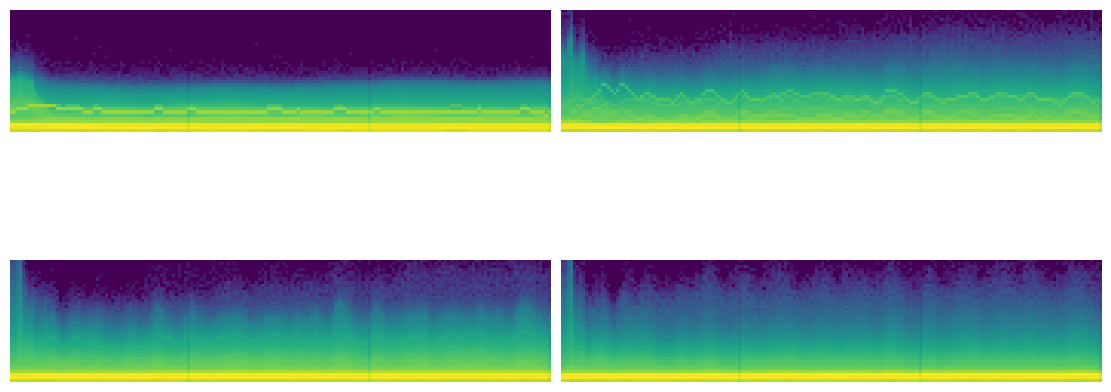

In [ ]:
astats.color_dim()

## LayerNorm

In [ ]:
#|export
class LayerNorm(nn.Module):
    def __init__(self,dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
    def forward(self,x):
        m = x.mean((1,2,3),keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m)/((v+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
#|export
def conv(ni,nf,ks=3,stride=2,act=nn.ReLU, norm = None, bias=True):
    layers = [nn.Conv2d(ni,nf,stride=stride, kernel_size=ks,padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [ ]:
#|export
def get_model(act=nn.ReLU,nfs=None,norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers =[conv(nfs[i],nfs[i+1],act=act,norm=norm) for i in range(len(nfs)-1)]   
    return nn.Sequential(*layers,conv(nfs[-1],10, act=None,norm=None,bias=False),nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.774,0.619,0,train
0.843,0.434,0,eval
0.862,0.381,1,train
0.858,0.394,1,eval
0.877,0.336,2,train
0.868,0.366,2,eval


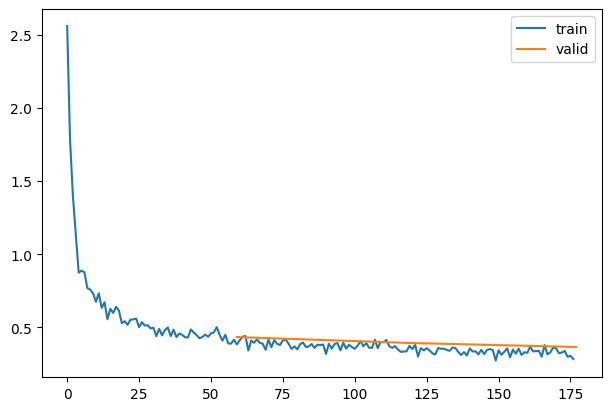

CPU times: user 1min 51s, sys: 2.64 s, total: 1min 53s
Wall time: 50.6 s


In [ ]:
set_seed(42)
model = get_model(act_gr,norm=LayerNorm).apply(iw)
learn = MomentumLearner(model,dls,F.cross_entropy,lr=0.2,cbs=cbs)
%time learn.fit(3)

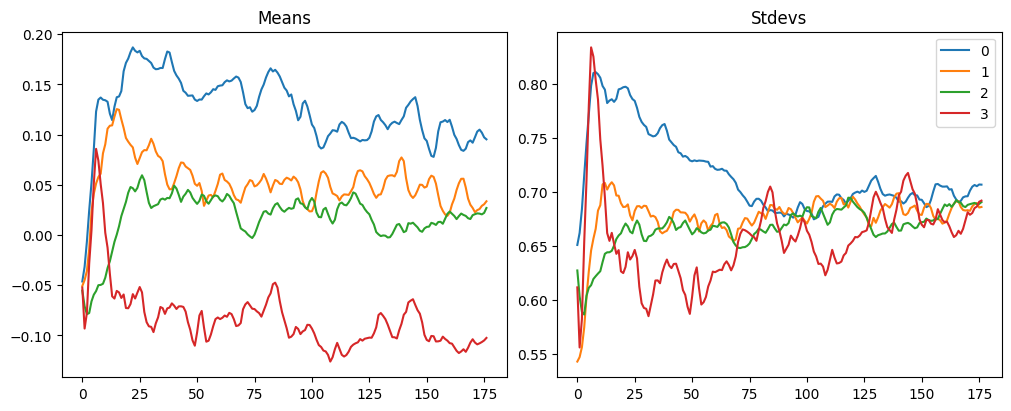

In [ ]:
astats.plot_stats()

## Batch Normalization

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf,mom = 0.1,eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
    def update_stats(self,x):
        m =x.mean((0,2,3), keepdims=True)
        v = x.var((0,2,3), keepdims=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v
    def forward(self,x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v= self.means, self.vars
        x = (x-m)/(v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.776,0.617,0,train
0.820,0.529,0,eval
0.869,0.356,1,train
0.855,0.431,1,eval
0.883,0.316,2,train
0.859,0.412,2,eval


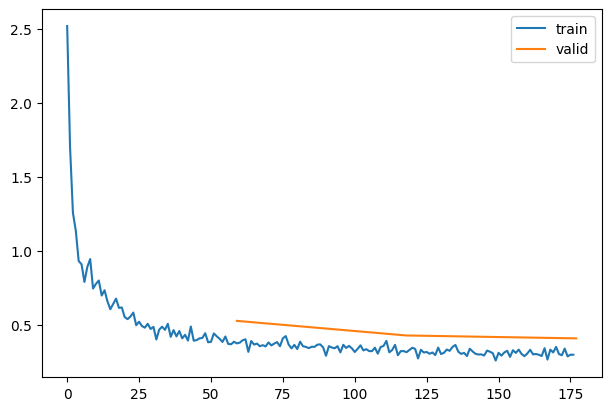

CPU times: user 1min 48s, sys: 2.44 s, total: 1min 51s
Wall time: 48.3 s


In [ ]:
model = get_model(act_gr,norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model,dls,F.cross_entropy,lr=0.4,cbs=cbs)
%time learn.fit(3)

### going towards 90% 

In [ ]:
dls = DataLoaders.from_dd(tds, 256)

accuracy,loss,epoch,train
0.834,0.462,0,train
0.854,0.399,0,eval
0.882,0.321,1,train
0.865,0.371,1,eval
0.894,0.288,2,train
0.876,0.345,2,eval


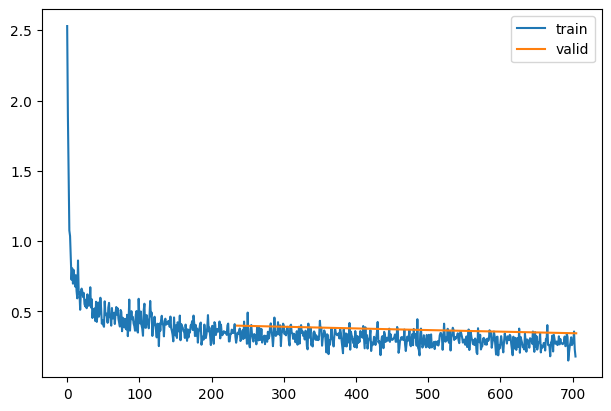

CPU times: user 4min 7s, sys: 5.75 s, total: 4min 13s
Wall time: 1min 41s


In [ ]:
set_seed(42)
model = get_model(act_gr, norm= nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model,dls,F.cross_entropy,lr=0.2,cbs=cbs)
%time learn.fit(3)

accuracy,loss,epoch,train
0.933,0.185,0,train
0.887,0.335,0,eval
0.935,0.178,1,train
0.885,0.348,1,eval


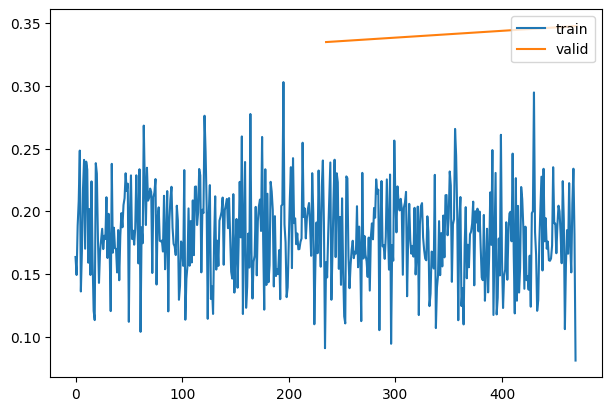

CPU times: user 2min 28s, sys: 4.01 s, total: 2min 32s
Wall time: 1min 5s


In [ ]:
learn = MomentumLearner(model,dls,F.cross_entropy,lr=0.08,cbs=cbs)
%time learn.fit(2)

In [ ]:
clean_mem()